# Setup Notebook

In [1]:
import json
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# load loss files
loss_files = glob('./losses/*.json')

# save the different loss files in the corresponding lists
toy_losses = []
mnist_losses = []
draw_mnist_losses = []
draw_omni_losses = []
for lf in loss_files:
    # get name of model and data
    filename = lf.split('\\')[-1]
    modelname = filename[:-14]
    dataname = filename.split('_')[1]

    # append file to list of files
    if dataname == 'mnist':
        if 'draw' in lf:
            draw_mnist_losses.append(lf)
            if modelname == 'draw':
                mnist_losses.append(lf)
        else:
            mnist_losses.append(lf)
    elif dataname == 'omniglot':
        draw_omni_losses.append(lf)
    else:
        toy_losses.append(lf)
print(draw_mnist_losses)
print(draw_omni_losses)
print(mnist_losses)
print(toy_losses)

['./losses\\draw2_mnist_10.json', './losses\\draw3_mnist_10.json', './losses\\draw4_mnist_10.json', './losses\\draw_mnist_10.json']
['./losses\\draw2_omniglot_10.json', './losses\\draw3_omniglot_10.json', './losses\\draw4_omniglot_10.json', './losses\\draw_omniglot_10.json']
['./losses\\draw_mnist_10.json', './losses\\flow_mnist_10.json', './losses\\lvae_mnist_10.json', './losses\\vae_mnist_10.json']
['./losses\\flow_8gaussians_10.json', './losses\\flow_checkerboard_10.json', './losses\\lvae_8gaussians_10.json', './losses\\lvae_checkerboard_10.json', './losses\\vae_8gaussians_10.json', './losses\\vae_checkerboard_10.json']


# Define Parameter Computations

Define functions to compute and visualize the different loss metrics.

In [3]:
def compute_params(loss):
    N = loss.shape[0]
    min_, max_, last = [], [], []
    
    first, exceeds = [], []
    for i in range(N):
        # remove nans from test loss
        tll = loss[i]
        tll = np.abs(tll[~np.isnan(tll)])

        if len(tll):
            min_.append(tll.min())
            max_.append(tll.max())
            last.append(tll[-1])

            first_ = tll[:5].mean()
            first.append(first_)
            exceeds.append(np.sum(first_ < tll[5:]))
    min_ = np.array(min_)
    max_ = np.array(max_)
    last = np.array(last)
    first = np.array(first)
    exceeds = np.array(exceeds)

    # store parameters
    return {
        'min': [min_.mean(), min_.std()],
        'max': [max_.mean(), max_.std()],
        'last': [last.mean(), last.std()],
        'first': [first.mean(), first.std()],
        'exceeds': [exceeds.mean(), exceeds.std()],
    }

In [4]:
def get_metric_mean(metrics, keys):
    return np.array([metrics[key][0] for key in keys])

def get_metric_std(metrics, keys):
    std = np.array([metrics[key][1] for key in keys])
    std[np.array(keys) == 'exceeds'] = 0
    return std

In [5]:
def visualize_metrics(metrics, xlabels, dataname):
    xs = np.arange(len(xlabels))

    plt.figure(figsize=(9, 5))
    n = len(metrics)
    width = 1/(n + 1)
    for i, model in enumerate(metrics):
        params = get_metric_mean(metrics[model], xlabels)
        err = get_metric_std(metrics[model], xlabels)
        plt.bar(xs-width*(i-(n-1)/2), params, yerr=err, width=width, label=model, capsize=10)
    plt.title(f'Loss metrics for {dataname}', fontsize=16)
    plt.ylabel('mean over 10 runs')
    plt.xticks(xs, xlabels, fontsize=14)
    plt.legend()
    plt.savefig(f'./losses/metrics_{dataname.replace(" ", "_")}.png')
    plt.show()

## Inspect Convergence on Toy Data
Compute metrics for the four different models on the two toy datasets `8gaussians` and `checkerboard`.

In [6]:
metrics_gauss = {}
metrics_check = {}
for tl in toy_losses:
    # load loss file
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    # get name of model and data
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    if dataname =='8gaussians':
        metrics_gauss[model] = params
    elif dataname == 'checkerboard':
        metrics_check[model] = params

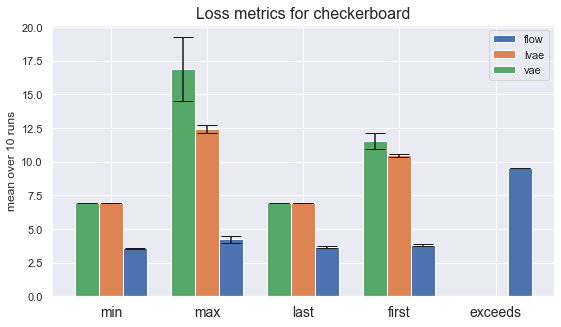

In [7]:
# Bar plot of loss metrics for checkerboard
xlabels = ['min', 'max', 'last', 'first', 'exceeds']
visualize_metrics(metrics_check, xlabels, 'checkerboard')

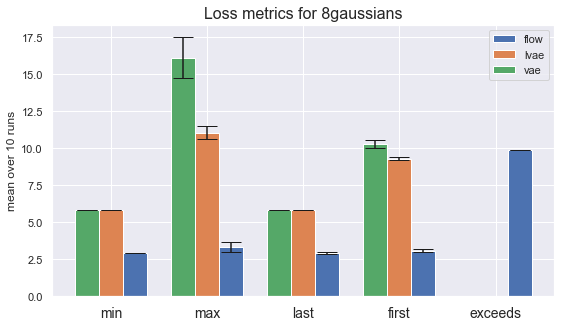

In [8]:
# Bar plot of loss metrics for 8gaussians
xlabels = ['min', 'max', 'last', 'first', 'exceeds']
visualize_metrics(metrics_gauss, xlabels, '8gaussians')

In [9]:
df = pd.DataFrame()
for tl in toy_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    loss = np.array(losses['val'])
    dict_ = {
        'model': model,
        'data': dataname,
    }
    params = compute_params(loss)
    for key in params.keys():
        dict_[key] = params[key][0]
    
    df = df.append(dict_, ignore_index=True)
df = df.sort_values('data')
print(df.round(2).to_markdown())

|    | model   | data         |   min |   max |   last |   first |   exceeds |
|---:|:--------|:-------------|------:|------:|-------:|--------:|----------:|
|  0 | flow    | 8gaussians   |  2.91 |  3.36 |   2.95 |    3.06 |       9.9 |
|  2 | lvae    | 8gaussians   |  5.82 | 11.04 |   5.82 |    9.29 |       0   |
|  4 | vae     | 8gaussians   |  5.82 | 16.11 |   5.82 |   10.3  |       0   |
|  1 | flow    | checkerboard |  3.58 |  4.23 |   3.63 |    3.79 |       9.5 |
|  3 | lvae    | checkerboard |  6.92 | 12.42 |   6.92 |   10.48 |       0   |
|  5 | vae     | checkerboard |  6.91 | 16.86 |   6.91 |   11.52 |       0   |


## Inspect Convergence on MNIST 

In [10]:
metrics_mnist = {}
for tl in mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    metrics_mnist[model] = params

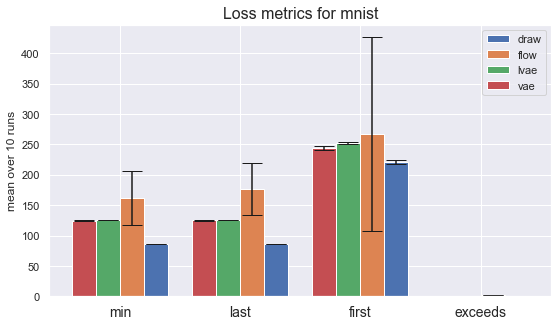

In [11]:
# plotting options
xlabels = ['min', 'last', 'first', 'exceeds'] #  'max', 
visualize_metrics(metrics_mnist, xlabels, 'mnist')

In [12]:
# table
df = pd.DataFrame()
for tl in mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    loss = np.array(losses['val'])
    dict_ = {
        'model': model,
        'data': dataname,
    }
    params = compute_params(loss)
    for key in params.keys():
        dict_[key] = params[key][0]
    
    df = df.append(dict_, ignore_index=True)
df.drop('data', inplace=True, axis=1)
print(df.round(2).to_markdown())

|    | model   |    min |           max |   last |   first |   exceeds |
|---:|:--------|-------:|--------------:|-------:|--------:|----------:|
|  0 | draw    |  86.33 | 373.11        |  86.52 |  221.09 |       0   |
|  1 | flow    | 162.19 |   4.64727e+18 | 176.54 |  267.04 |       2.2 |
|  2 | lvae    | 125.87 | 306.51        | 126.11 |  252.48 |       0   |
|  3 | vae     | 124.65 | 283.04        | 125.07 |  243.93 |       0.1 |


## Inspect Convergence for Different DRAW Models 
Inspect convergence metrics for four different DRAW implementations on the MNIST and Omniglot datasets.
- draw: Standard DRAW implementation with the base attention module.
- draw2: draw, but without using the error image `x_hat`
- draw3: draw, but without iteratively updating the canvas, but instead setting `c_t = write(h_dec^t)`
- draw4: draw, but without both without the error image and the canvas iteration updating.

In [13]:
# Compute metrics for the DRAW models trained on MNIST
metrics_draw_mnist = {}
for tl in draw_mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    metrics_draw_mnist[model] = params

# Compute metrics for the DRAW models trained on Omniglot
metrics_draw_omni = {}
for tl in draw_omni_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    metrics_draw_omni[model] = params

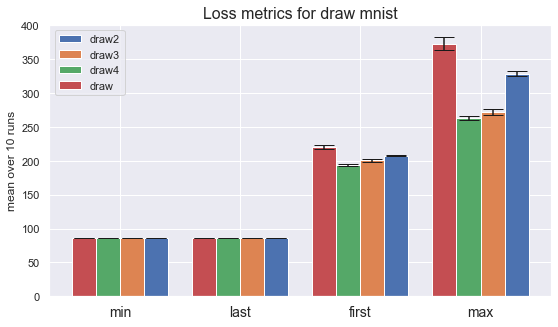

In [14]:
# Visualize loss metrics for the different draw models on MNIST
xlabels = ['min', 'last', 'first', 'max']
visualize_metrics(metrics_draw_mnist, xlabels, 'draw mnist')

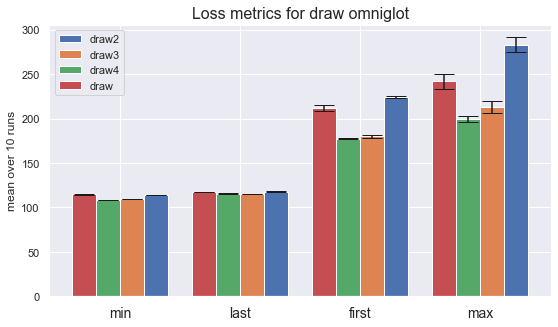

In [15]:
# Visualize loss metrics for the different draw models on Omniglot
xlabels = ['min', 'last', 'first', 'max']
visualize_metrics(metrics_draw_omni, xlabels, 'draw omniglot')

In [16]:
# table
df = pd.DataFrame()
draw_losses = draw_omni_losses + draw_mnist_losses
for tl in draw_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    loss = np.array(losses['val'])
    dict_ = {
        'model': model,
        'data': dataname,
    }
    params = compute_params(loss)
    for key in params.keys():
        dict_[key] = params[key][0]
    
    df = df.append(dict_, ignore_index=True)
# df.drop('data', inplace=True, axis=1)
print(df.round(2).to_markdown())

|    | model   | data     |    min |    max |   last |   first |   exceeds |
|---:|:--------|:---------|-------:|-------:|-------:|--------:|----------:|
|  0 | draw2   | omniglot | 113.67 | 283.27 | 117.62 |  223.96 |         0 |
|  1 | draw3   | omniglot | 109.56 | 213.01 | 114.96 |  180.19 |         0 |
|  2 | draw4   | omniglot | 108.32 | 199.68 | 115.28 |  177.38 |         0 |
|  3 | draw    | omniglot | 114.75 | 242.02 | 117.42 |  211.93 |         0 |
|  4 | draw2   | mnist    |  86.02 | 328.89 |  86.2  |  207.49 |         0 |
|  5 | draw3   | mnist    |  85.85 | 271.92 |  85.99 |  200.6  |         0 |
|  6 | draw4   | mnist    |  85.67 | 262.82 |  85.79 |  193.82 |         0 |
|  7 | draw    | mnist    |  86.33 | 373.11 |  86.52 |  221.09 |         0 |


# Compute Number of Parameters
Compute number of total parameters and trainable parameters for each model used on both MNIST and the toy data.

In [17]:
from models import DRAW, VariationalAutoencoder, LadderVAE, \
    Flow, AffineCouplingBijection, StandardNormal, Squeeze2d, Augment, \
    UniformDequantization, DenseNet, ElementwiseParams2d, \
    StandardUniform, Slice, ActNormBijection2d, Conv1x1, \
    Reverse, ElementwiseParams, ActNormBijection, \
    DRAW2, DRAW3, DRAW4
    
import torch.nn as nn

In [18]:
def n_params(model):
    """Compute number of parameters in the given model"""
    return sum([np.prod(p.size()) for p in model.parameters()])

## Instantiate Toy Data Models
Instantiate FLow, Ladder VAE and Standard VAE models with same dimensions as the trained models on the toy data.

In [19]:
# define config
config = {
    'as_beta': True
}
x_dim = [2, 4]

In [20]:
# Instantiate flow model
def net():
    return nn.Sequential(
        nn.Linear(1, 200), nn.ReLU(),
        nn.Linear(200, 100), nn.ReLU(),
        nn.Linear(100, 2), ElementwiseParams(2)
    )

model_flow_toy = Flow(
    base_dist=StandardNormal((2,)),
    transforms=[
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
        AffineCouplingBijection(net()), ActNormBijection(2),
    ]
)

In [21]:
# Instantiate Ladder VAE model
config['h_dim'] = [128, 128, 128]
config['z_dim'] = [4, 4, 4]
model_lvae_toy = LadderVAE(config, x_dim)

In [22]:
# Instantate Standard VAE model
config['h_dim'] = [128, 128, 128]
config['z_dim'] = 4
model_vae_toy = VariationalAutoencoder(config, x_dim)

## Instantiate MNIST Models
Instantiate Flow, Ladder VAE, Standard VAE and DRAW models with same dimensions as the trained models on the MNIST data.

In [23]:
# define config
config = {
    'as_beta': True
}
x_shape = [28, 28]
x_dim = x_shape[0] * x_shape[1]

In [24]:
# Instantiate Flow model
def net(channels):
    return nn.Sequential(
        DenseNet(
            in_channels=channels//2,
            out_channels=channels,
            num_blocks=1,
            mid_channels=64,
            depth=8,
            growth=16,
            dropout=0.0,
            gated_conv=True,
            zero_init=True
        ),
        ElementwiseParams2d(2)
    )

model_flow = Flow(
    base_dist=StandardNormal((8, 7, 7)),
    transforms=[
        UniformDequantization(num_bits=1),
        Augment(StandardUniform((1, 28, 28)), x_size=1),
        AffineCouplingBijection(net(2)), ActNormBijection2d(2), Conv1x1(2),
        AffineCouplingBijection(net(2)), ActNormBijection2d(2), Conv1x1(2),
        AffineCouplingBijection(net(2)), ActNormBijection2d(2), Conv1x1(2),
        AffineCouplingBijection(net(2)), ActNormBijection2d(2), Conv1x1(2),
        Squeeze2d(), Slice(StandardNormal((4, 14, 14)), num_keep=4),
        AffineCouplingBijection(net(4)), ActNormBijection2d(4), Conv1x1(4),
        AffineCouplingBijection(net(4)), ActNormBijection2d(4), Conv1x1(4),
        AffineCouplingBijection(net(4)), ActNormBijection2d(4), Conv1x1(4),
        AffineCouplingBijection(net(4)), ActNormBijection2d(4), Conv1x1(4),
        Squeeze2d(), Slice(StandardNormal((8, 7, 7)), num_keep=8),
        AffineCouplingBijection(net(8)), ActNormBijection2d(8), Conv1x1(8),
        AffineCouplingBijection(net(8)), ActNormBijection2d(8), Conv1x1(8),
        AffineCouplingBijection(net(8)), ActNormBijection2d(8), Conv1x1(8),
        AffineCouplingBijection(net(8)), ActNormBijection2d(8), Conv1x1(8),
    ]
)

In [25]:
# Instantiate Ladder VAE model
config['h_dim'] = [512, 256, 256]
config['z_dim'] = [64, 64, 64]
model_lvae = LadderVAE(config, x_dim)

In [26]:
# Instantate Standard VAE model
config['h_dim'] = [512, 256, 128, 64]
config['z_dim'] = 64
model_vae = VariationalAutoencoder(config, x_dim)

In [27]:
# Instante DRAW model (and deviations)
config['h_dim'] = 256
config['z_dim'] = 32
config['T'] = 10
config['N'] = 12
config['attention'] = 'base'
model_draw = DRAW(config, x_shape)
model_draw2 = DRAW2(config, x_shape)
model_draw3 = DRAW3(config, x_shape)
model_draw4 = DRAW4(config, x_shape)

## Comptue Params
Compute and compare number of parameters for each model, both for their MNIST and toy data versions.

In [28]:
print('Model\tMNIST\tToy')
for name, model, model_toy in [
    ('flow', model_flow, model_flow_toy), 
    ('lvae', model_lvae, model_lvae_toy), 
    ('vae', model_vae, model_vae_toy), 
    ('draw', model_draw, None),
    ('draw2', model_draw2, None),
    ('draw3', model_draw3, None),
    ('draw4', model_draw4, None)
]:
    print_out = f'{name}\t{n_params(model)}\t'
    if model_toy == None:
        print_out += 'n/a'
    else:
        print_out += f'{n_params(model_toy)}'
    print(print_out)

Model	MNIST	Toy
flow	3634680	82824
lvae	1464464	79164
vae	1162000	68620
draw	3262304	n/a
draw2	2459488	n/a
draw3	3262304	n/a
draw4	2459488	n/a
